# Lesson 87 - putting it all together with multi-class classification

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch import nn

In [2]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

In [3]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [4]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)

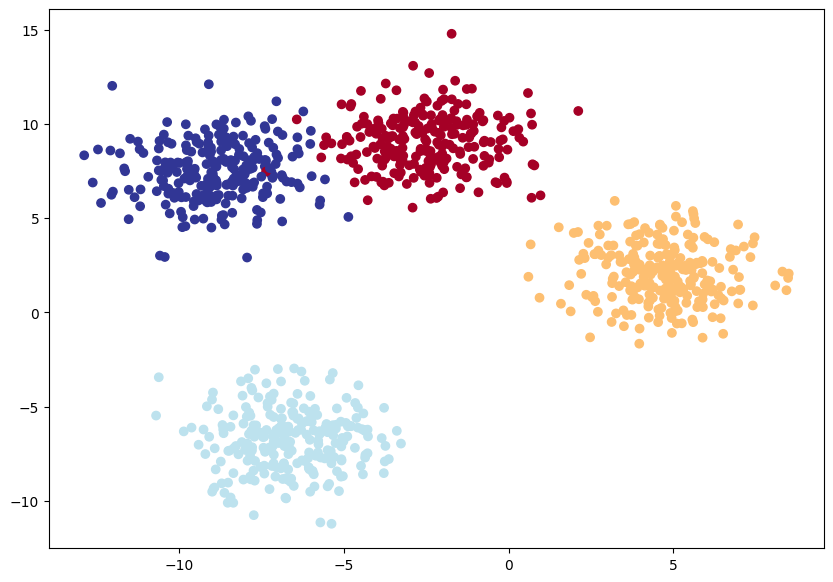

In [5]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [7]:
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

In [8]:
torch.unique(X_blob_train), torch.unique(y_blob_train)

(tensor([-12.8932, -12.6338, -12.4747,  ...,  12.7091,  13.0945,  14.7934]),
 tensor([0, 1, 2, 3]))

In [9]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8): #presetting some params
    """
    Initializes multi-class classification model
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# creating instance of blob model and sending it to device
blob_model = BlobModel(input_features = 2, output_features=4, hidden_units=8).to(device)
blob_model


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [10]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = blob_model.parameters(),
                            lr = 0.001)

In [11]:
# making untrained preditions
blob_model(X_blob_test)[:5]

tensor([[-0.3518,  0.4049,  0.1785,  0.3912],
        [-0.0398,  0.7619, -0.2911,  0.0729],
        [ 0.6033,  0.0030,  1.3949, -0.0461],
        [-0.0530,  0.2651,  0.2280,  0.1973],
        [-0.4515,  0.8685, -0.2044,  0.2672]], grad_fn=<SliceBackward0>)

In [12]:
# checking where model params are
next(blob_model.parameters()).device

device(type='cpu')

In [13]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [14]:
# creating training and testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  blob_model.train()

  # forward pass
  y_logits = blob_model(X_blob_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1) # multiclass

  # loss
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred = y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #testing
  blob_model.eval()
  with torch.inference_mode():
    test_logits = blob_model(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                    y_pred = test_preds)

  # printing out what's happening
  if epoch %10==0:
    print(f"Epoch {epoch} | Loss: {loss} | accuracy {acc} | test loss {test_loss} | test accuracy {test_acc}")


Epoch 0 | Loss: 1.3359276056289673 | accuracy 35.75 | test loss 1.3240344524383545 | test accuracy 35.5
Epoch 10 | Loss: 1.309200644493103 | accuracy 37.75 | test loss 1.2962626218795776 | test accuracy 38.0
Epoch 20 | Loss: 1.283411979675293 | accuracy 39.5 | test loss 1.269437313079834 | test accuracy 40.0
Epoch 30 | Loss: 1.2584680318832397 | accuracy 42.0 | test loss 1.243394136428833 | test accuracy 41.5
Epoch 40 | Loss: 1.2344664335250854 | accuracy 44.0 | test loss 1.218234658241272 | test accuracy 43.0
Epoch 50 | Loss: 1.2114086151123047 | accuracy 46.875 | test loss 1.1940217018127441 | test accuracy 44.5
Epoch 60 | Loss: 1.1891742944717407 | accuracy 48.0 | test loss 1.1706961393356323 | test accuracy 45.5
Epoch 70 | Loss: 1.1677618026733398 | accuracy 49.75 | test loss 1.1482757329940796 | test accuracy 46.5
Epoch 80 | Loss: 1.1472362279891968 | accuracy 52.0 | test loss 1.1267688274383545 | test accuracy 49.0
Epoch 90 | Loss: 1.127541422843933 | accuracy 59.0 | test loss 1.

In [15]:
 import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f: # create  a file helper_functions.py with write permissions
    f.write(request.content) # write in the file the content of the requests


from helper_functions import plot_predictions, plot_decision_boundary

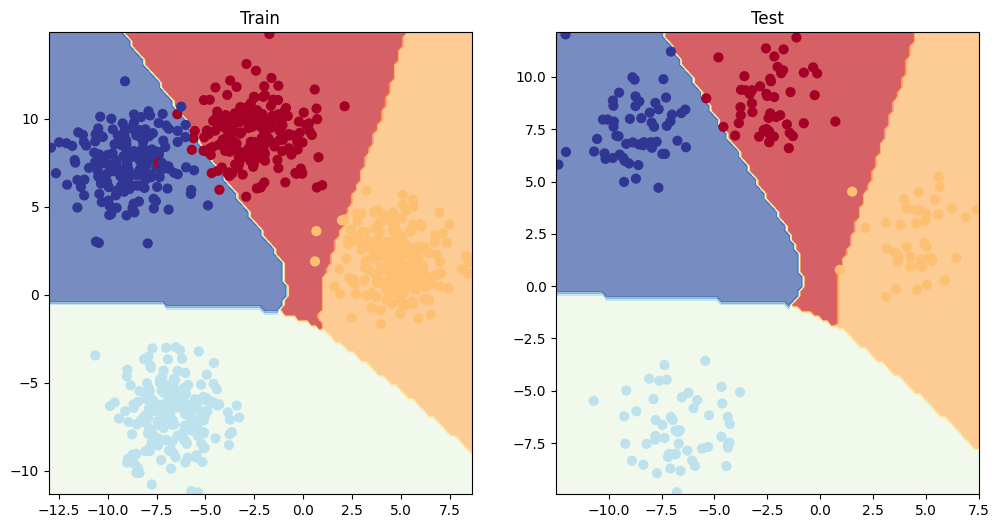

In [16]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1) # rows, #total_plots, column
plt.title("Train")
plot_decision_boundary(blob_model, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(blob_model, X_blob_test, y_blob_test)

# Lesson 93 Classification Metrics

In [17]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.6 MB/s eta 0:00:00


In [19]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy().to(device)

TypeError: ignored

In [ ]:
torchmetric_accuracy